In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report
from id3 import Id3Estimator

In [2]:
%matplotlib inline

In [3]:
dir_ = 'HASYv2/'

## LABELS

In [4]:
def read_csv(path):
    return pd.read_csv(dir_ + path)

In [5]:
whole_dataset = read_csv('hasy-data-labels.csv')
print(whole_dataset.head())
print(whole_dataset.info())

                     path  symbol_id latex  user_id
0  hasy-data/v2-00000.png         31     A       50
1  hasy-data/v2-00001.png         31     A       10
2  hasy-data/v2-00002.png         31     A       43
3  hasy-data/v2-00003.png         31     A       43
4  hasy-data/v2-00004.png         31     A     4435
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168233 entries, 0 to 168232
Data columns (total 4 columns):
path         168233 non-null object
symbol_id    168233 non-null int64
latex        168233 non-null object
user_id      168233 non-null int64
dtypes: int64(2), object(2)
memory usage: 5.1+ MB
None


In [6]:
# Read symbols for all classification classes
symbols = read_csv('symbols.csv')
print(symbols.head())
print(symbols.info())

   symbol_id latex  training_samples  test_samples
0         31     A               137            22
1         32     B                53             8
2         33     C               120            14
3         34     D                50             8
4         35     E                48             6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 4 columns):
symbol_id           369 non-null int64
latex               369 non-null object
training_samples    369 non-null int64
test_samples        369 non-null int64
dtypes: int64(3), object(1)
memory usage: 11.7+ KB
None


## IMAGE PREPROCESSING

In [7]:
def remove_transparency(im, bg_colour=(255, 255, 255)):

    # Only process if image has transparency 
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL 
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format

        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

def preprocess_img(path):
    # Open Image
    im = Image.open(dir_ + path)
    
    # Resize image to 32 by 32
    if im.size != (32,32):
        im = im.resize((32,32))
        
    # Convert image to a single greyscale channel
    im = remove_transparency(im).convert('L')
    
    # Convert image to numpy array
    I = np.asarray(im)
    
    #Close image
    im.close()
    
    return I

### Create Dataset as x and y

In [8]:
def populate_images(dataset):
    temp = []
    for i in range(len(dataset)):
        path = dataset.iloc[i]['path']
        pathsplit = path.split('/')
        if len(pathsplit) > 2:
            path = '/'.join([pathsplit[-2],pathsplit[-1]])
        img = preprocess_img(path)
        temp.append(img)
    dataset['img'] = [i for i in temp]
    return dataset

def convert_to_one_hot_encode(data, no_categories):
    data = np.array(data).reshape(-1)
    print('len of dataset', len(data))
    return np.eye(no_categories)[data]

In [9]:
whole_dataset = populate_images(whole_dataset)

#### Reset symbol names to start from 0 to 368

In [10]:
# change name of previous symbol
symbols['old_symbol'] = symbols['symbol_id']
symbols = symbols.drop('symbol_id', axis=1)

# add new id according to index of character
symbols['new_id'] = symbols.index

# make a symbols dict that references each symbol_id to the new symbol
symbols_dict = {}
for i in range(len(symbols)):
    symbols_dict[symbols['old_symbol'][i]] = symbols['new_id'][i]

In [11]:
for i in range(len(whole_dataset)):
    old = whole_dataset['symbol_id'][i]
    new = symbols_dict[old]
    whole_dataset['symbol_id'][i] = new

In [12]:
def gen_x_y_train_test(dataset,test_size=0.2):
    x = np.array(list(dataset['img']))
    y = np.array(list(dataset['symbol_id']))
    # x = x.reshape((x.shape[0],1,input_shape[1],input_shape[2]))
    x = x.reshape((x.shape[0],-1))
    
    # Normalize data to 0-1
    x = x.astype("float32") / 255.0
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = gen_x_y_train_test(whole_dataset, test_size=0.2)

## ID3

In [21]:
id3 = Id3Estimator(prune=True)

In [22]:
id3.fit(X_train, y_train)

Id3Estimator(gain_ratio=False, is_repeating=False, max_depth=None,
             min_entropy_decrease=0.0, min_samples_split=2, prune=True)

In [23]:
y_pred = id3.predict(X_test)

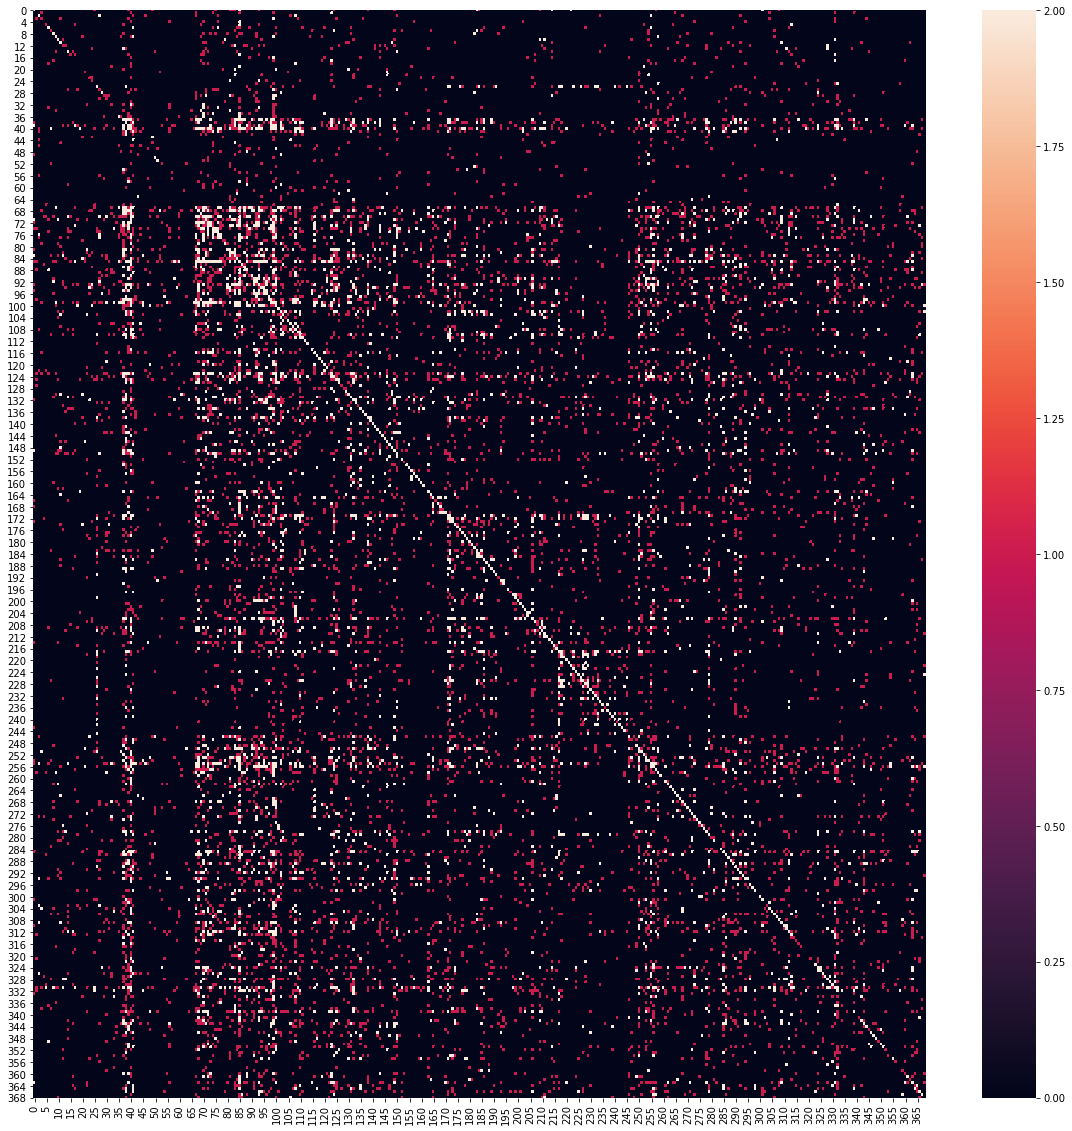

In [24]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs7 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs7, robust=True)

In [25]:
cr7 = classification_report(y_test, y_pred, digits=4)
print(cr7)

              precision    recall  f1-score   support

           0     0.1220    0.1562    0.1370        32
           1     0.0000    0.0000    0.0000        12
           2     0.2857    0.3704    0.3226        27
           3     0.0769    0.0833    0.0800        12
           4     0.0000    0.0000    0.0000        11
           5     0.0909    0.0909    0.0909        11
           6     0.2353    0.1667    0.1951        24
           7     0.0769    0.0769    0.0769        13
           8     0.1905    0.2000    0.1951        20
           9     0.1364    0.1429    0.1395        21
          10     0.1154    0.1579    0.1333        19
          11     0.1667    0.2727    0.2069        22
          12     0.0357    0.0417    0.0385        24
          13     0.0000    0.0000    0.0000        21
          14     0.0625    0.1176    0.0816        17
          15     0.1429    0.0714    0.0952        14
          16     0.0000    0.0000    0.0000        13
          17     0.0000    

In [26]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score is ", int(acc*100), "%")

Accuracy Score is  34 %


## Decision Tree Classifier

In [15]:
clf = DecisionTreeClassifier(criterion='entropy')

In [16]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [17]:
y_pred = clf.predict(X_test)

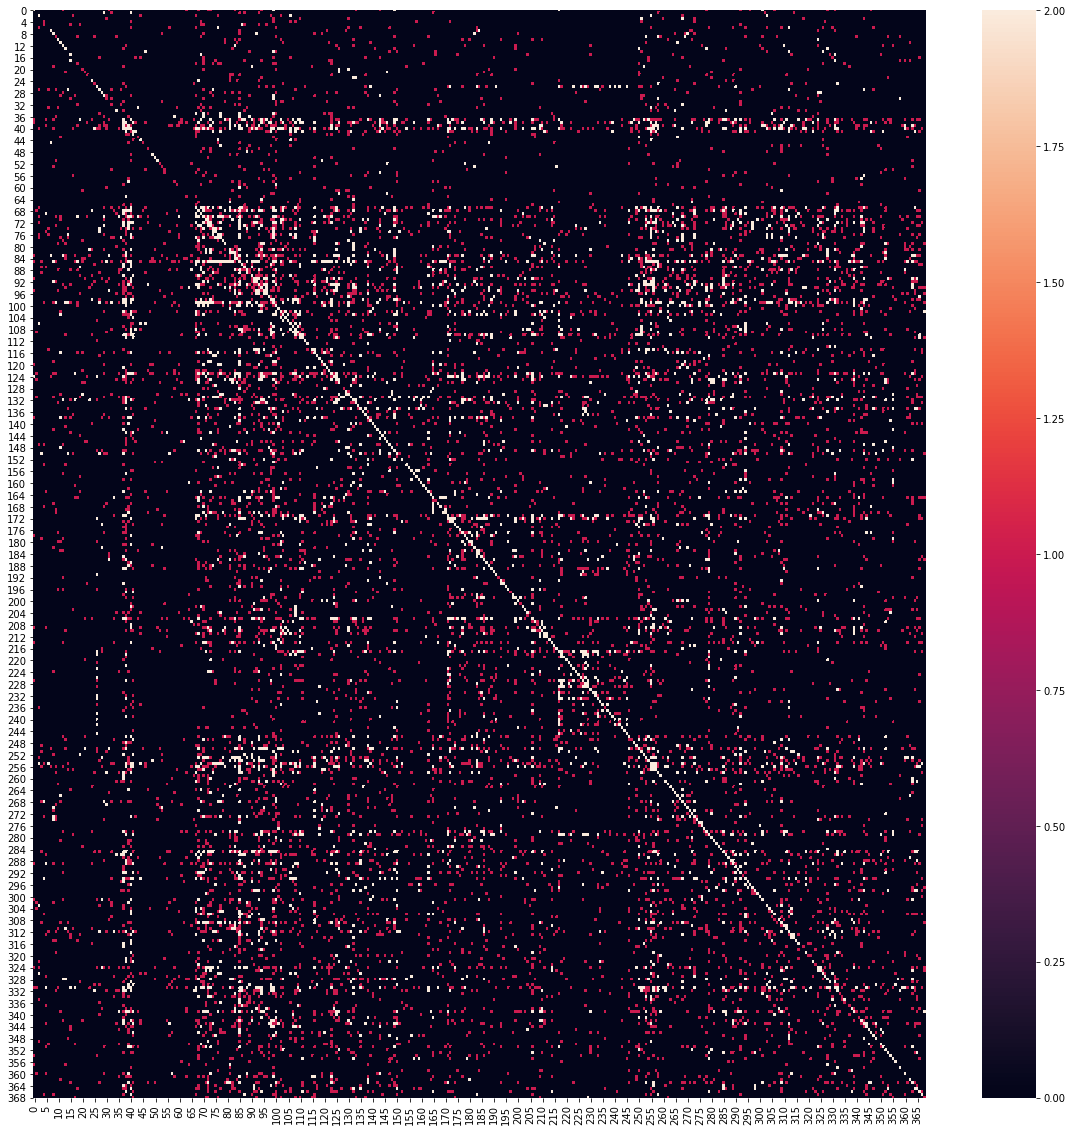

In [18]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs5 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs5, robust=True)

In [19]:
cr5 = classification_report(y_test, y_pred, digits=4)
print(cr5)

              precision    recall  f1-score   support

           0     0.1304    0.0938    0.1091        32
           1     0.0000    0.0000    0.0000        12
           2     0.1569    0.2963    0.2051        27
           3     0.0000    0.0000    0.0000        12
           4     0.0714    0.0909    0.0800        11
           5     0.0000    0.0000    0.0000        11
           6     0.0000    0.0000    0.0000        24
           7     0.3000    0.2308    0.2609        13
           8     0.1351    0.2500    0.1754        20
           9     0.0455    0.0476    0.0465        21
          10     0.3125    0.2632    0.2857        19
          11     0.3171    0.5909    0.4127        22
          12     0.1613    0.2083    0.1818        24
          13     0.1290    0.1905    0.1538        21
          14     0.0000    0.0000    0.0000        17
          15     0.1000    0.1429    0.1176        14
          16     0.0000    0.0000    0.0000        13
          17     0.0000    

In [20]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score is ", int(acc*100), "%")

Accuracy Score is  36 %


## Edge Detection for Decision Tree Classifier

cv2.imshow('edges', edges_laplacian)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [32]:
def gen_x_y_train_test_edges(dataset,test_size=0.2):
    x = np.array(list(dataset['img']))
    y = np.array(list(dataset['symbol_id']))
    # x = x.reshape((x.shape[0],1,input_shape[1],input_shape[2]))
    x = cv2.Laplacian(x, cv2.CV_64F)
    x = x.reshape((x.shape[0],-1))
    
    # Normalize data to 0-1
    x = x.astype("float32") / 255.0
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
    return X_train, X_test, y_train, y_test

In [33]:
X_train, X_test, y_train, y_test = gen_x_y_train_test_edges(whole_dataset, test_size=0.2)

In [34]:
clf1 = DecisionTreeClassifier(criterion='entropy')

In [35]:
clf1.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [36]:
y_pred = clf1.predict(X_test)

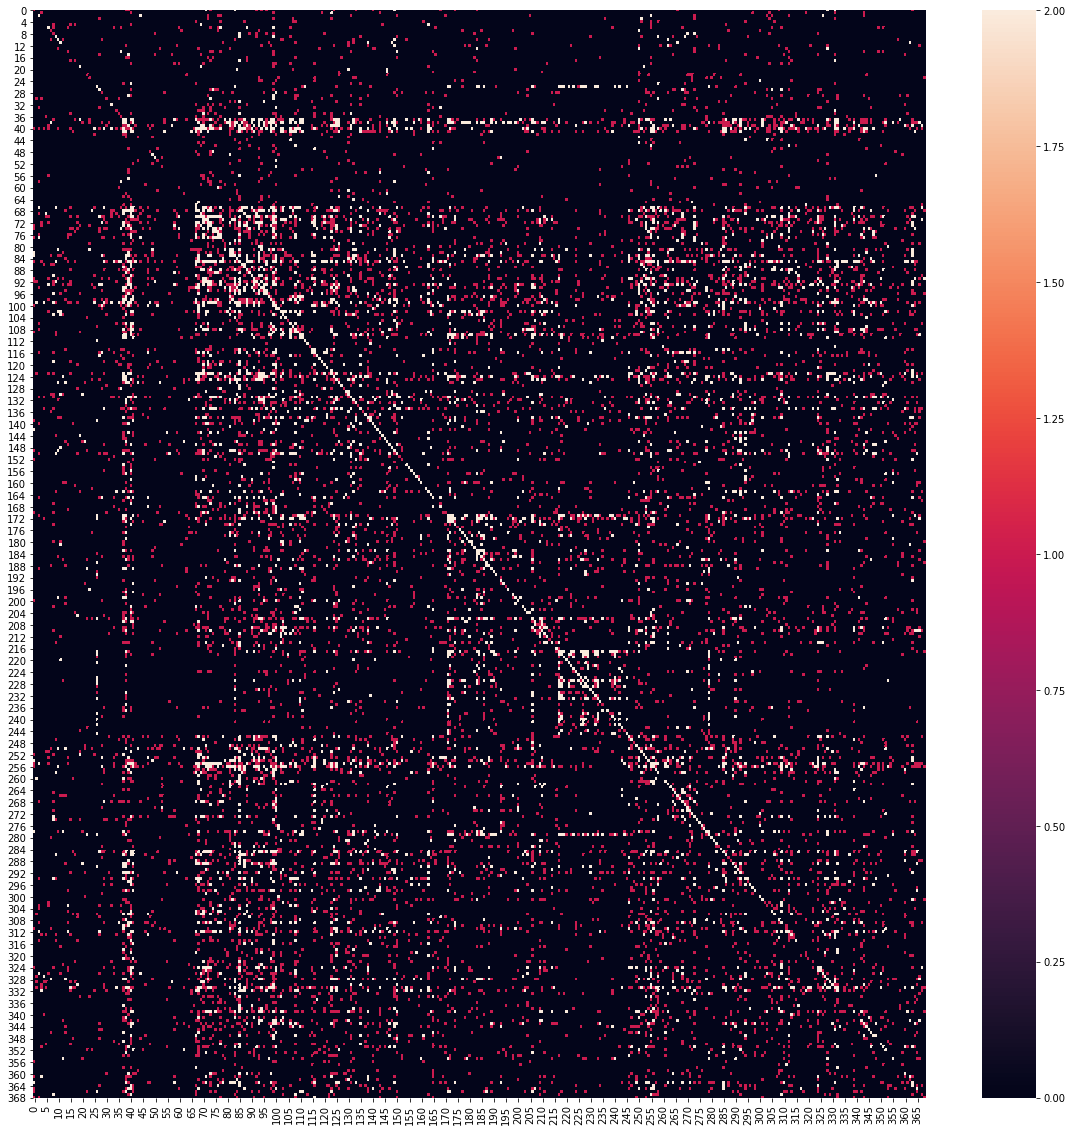

In [37]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs6 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs6, robust=True)

In [38]:
cr6 = classification_report(y_test, y_pred, digits=4)
print(cr6)

              precision    recall  f1-score   support

           0     0.0244    0.0312    0.0274        32
           1     0.0000    0.0000    0.0000        12
           2     0.1282    0.1852    0.1515        27
           3     0.0000    0.0000    0.0000        12
           4     0.0000    0.0000    0.0000        11
           5     0.0000    0.0000    0.0000        11
           6     0.1053    0.0833    0.0930        24
           7     0.0625    0.0769    0.0690        13
           8     0.0238    0.0500    0.0323        20
           9     0.0741    0.0952    0.0833        21
          10     0.0714    0.1053    0.0851        19
          11     0.1481    0.1818    0.1633        22
          12     0.0000    0.0000    0.0000        24
          13     0.0000    0.0000    0.0000        21
          14     0.0500    0.0588    0.0541        17
          15     0.0000    0.0000    0.0000        14
          16     0.0000    0.0000    0.0000        13
          17     0.0909    

In [39]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score is ", int(acc*100), "%")

Accuracy Score is  28 %
